In [11]:
import numpy as np
import pickle
%matplotlib inline
import matplotlib.pyplot as plt
from scipy import signal
import scipy.constants as const
import warnings
warnings.filterwarnings('ignore')
from modelfitting import rotationalProfile
import modelfitting as mf
import os
homedir = os.path.expanduser('~')
from astropy.io import fits

In [4]:
# Open data
data_filename = f'{homedir}/uoedrive/data/CRIRES/fainterspectral-fits_6.pickle'
with open(data_filename, 'rb') as f:
    ret = pickle.load(f, encoding="latin1")

# In this tutorial just use data from one wavelength band 
band = 0

In [5]:
# Open model
from astropy.table import Table
model_filename = f'{homedir}/uoedrive/data/BTSettlModels/CIFIST2015/lte015.0-5.0-0.0a+0.0.BT-Settl.spec.fits'
model = Table.read(model_filename, format='fits')
model['wl'] = model['Wavelength']
model['flux'] = model['Flux']

lowerlim = ret['wobs'][band].min() - 0.003  # TODO: where this value from
upperlim = ret['wobs'][band].max() + 0.003
tind = (model['wl'] > lowerlim) * (model['wl'] < upperlim) # get index of template spec where wl covered by obs
lam_template = model['wl'][tind]
template = model['flux'][tind]
template = template/np.median(template) # normalize flux wrt to template median level in this wl band

In [6]:
vsini = 2.75467419e+01 # km/s
lld = 2.42449751e-01   # linear limb darkening coefficient
rv = 1.50501728e-04    # radial velocity of BD / c
wavelength_coefs = [-1.71924678e-14, -2.11171020e-04,  1.30434527e-02,  2.28755948e+00]
continuum_coefs = [-1.98152556e-02, 1.09272772e+00]
npix = 1024
lam_template = np.array(lam_template, copy=False)
template = np.array(template, copy=False)
pix = np.arange(npix, dtype=float)/npix

In [7]:
# Create model-convolution Kernel
d_lam_per_pixel = np.diff(lam_template).mean()
lam_central = lam_template.mean()
d_vz_per_pixel = d_lam_per_pixel * const.c / lam_central
print(f"lam central: {lam_central} um")
print(f"delta lam per pixel: {d_lam_per_pixel} um")
print(f"delta vz per pixel: {d_vz_per_pixel} m/s")

vz_max = 1200.*vsini                      # TODO: why need a larger range than vmax
pix_max = vz_max / d_vz_per_pixel
pix_grid = np.arange(-int(pix_max), int(pix_max+1))
vz_grid = pix_grid * d_vz_per_pixel
print("grid size:", vz_grid.shape)

lam central: 2.2939023971557617 um
delta lam per pixel: 5.000031251256587e-06 um
delta vz per pixel: 653.4592146333782 m/s
grid size: (101,)


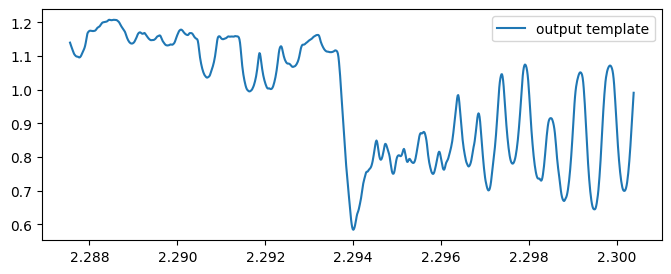

In [8]:
# Create rotational profile and convolve with template
rotational_profile = rotationalProfile([vsini*1000., lld, 0], vz_grid) # vz / vLimb = delta_lam / delta_lam_limb
rotational_profile /= rotational_profile.sum()

new_template = np.convolve(template, rotational_profile, 'same')

# Shift template to specified RV & interpolate to wavelength grid
lam = np.polyval(wavelength_coefs, pix)
result_template = np.interp(lam, lam_template*(1.+rv), new_template, left=0., right=0.)

# Multiply by appropriate normalization polynomial
result_template *= np.polyval(continuum_coefs, pix)
plt.figure(figsize=(8,3))
plt.plot(lam, result_template, label="output template")
plt.legend()
plt.show()

#### Rotational profile

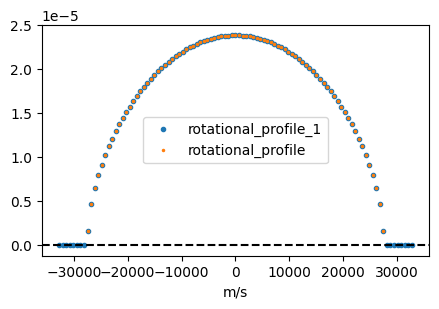

In [9]:
delta_lam_Limb = vsini*1000. # in m/s; the rotational displacement at the stellar limb 
                             # (any unit, as long as same as delta_lam)
eps = lld                    # linear limb darkening coeff
delta_lam = vz_grid          # in m/s; array of offset from wl center (len=100)

a = 1. - (delta_lam/delta_lam_Limb)**2
rot_profile = (4*(1.-eps) * np.sqrt(a) + np.pi*eps*a) / (2*np.pi * delta_lam_Limb * (1. - eps/3.))
rot_profile_1 = rot_profile.copy()
rot_profile_1[a<0] = 0
plt.figure(figsize=(5,3))
plt.plot(delta_lam, rot_profile_1, ".", label="rotational_profile_1")
plt.plot(delta_lam, rot_profile, ".", markersize=3, label="rotational_profile")
plt.axhline(y=0, color="black", linestyle='--')
plt.xlabel("m/s")
plt.legend()
plt.show()

### Play with parameters

In [12]:
chipmods = fits.getdata("result/IGRINS_W1049B_H_chipmods_lte015.0-5.0.fits")
chiplams = fits.getdata("result/IGRINS_W1049B_H_chiplams_lte015.0-5.0.fits")
results = Table.read('result/IGRINS_W1049B_H_fitting_results_lte015.0-5.0.txt', format='ascii')


In [13]:
results

order,obs,chisq,vsini,limbdark,rv
int64,int64,float64,float64,float64,float64
0,0,23064.41293939637,44.032555593941844,0.10752792494191087,9.868189010315457e-05
0,1,23064.41293939637,44.032555593941844,0.10752792494191087,9.868189010315457e-05
0,2,25314.77156592817,23.10408268427869,0.3521531608985315,9.682387911334411e-05
0,3,25314.77156592817,23.10408268427869,0.3521531608985315,9.682387911334411e-05
0,4,25314.77156592817,23.10408268427869,0.3521531608985315,9.682387911334411e-05
0,5,25314.77156592817,23.10408268427869,0.3521531608985315,9.682387911334411e-05
0,6,25314.77156592817,23.10408268427869,0.3521531608985315,9.682387911334411e-05
0,7,25314.77156592817,23.10408268427869,0.3521531608985315,9.682387911334411e-05
0,8,25434.361930836567,22.48203239236763,0.33150247445014513,7.921457286342097e-05


In [ ]:
mf.modelspec_template()